<a href="https://colab.research.google.com/github/plawanrath/pytorch_basics/blob/main/CarsPredictionModelUsingResnet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!nvidia-smi

Sat Apr 15 23:50:15 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   50C    P8     9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
import torch
import torchvision.transforms as transforms
import torchvision.datasets as datasets

# Define transformations to apply to the dataset
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load the dataset and apply the transformations
train_set = datasets.StanfordCars(root='./data', split='train', download=True, transform=transform)
test_set = datasets.StanfordCars(root='./data', split='test', download=True, transform=transform)

# Create data loaders to load the data in batches
train_loader = torch.utils.data.DataLoader(train_set, batch_size=32, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=32, shuffle=False)

100%|██████████| 330960/330960 [00:01<00:00, 268591.53it/s]


Extracting data/stanford_cars/car_devkit.tgz to data/stanford_cars


100%|██████████| 979269282/979269282 [00:59<00:00, 16496341.55it/s]


Extracting data/stanford_cars/cars_train.tgz to data/stanford_cars
Using downloaded and verified file: data/stanford_cars/car_devkit.tgz
Extracting data/stanford_cars/car_devkit.tgz to data/stanford_cars


100%|██████████| 977350468/977350468 [01:00<00:00, 16245477.27it/s]


Extracting data/stanford_cars/cars_test.tgz to data/stanford_cars


100%|██████████| 185758/185758 [00:00<00:00, 210002.07it/s]


In [15]:
# Define hyperparameters and other settings
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_classes = 196
lr = 0.01
num_epochs = 15

In [16]:
# Define the training and test functions
def train(model, train_loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    for i, (inputs, labels) in enumerate(train_loader):
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
    return running_loss / len(train_loader.dataset)

def test(model, test_loader, criterion, device):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            running_corrects += torch.sum(preds == labels.data)
    return running_loss / len(test_loader.dataset), running_corrects.double() / len(test_loader.dataset)

In [17]:
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
from tqdm.auto import tqdm


# Initialize the model, loss function, and optimizer

# Using pretrained resnet34 + untrained Linear regression as the last layer
model = models.resnet34(pretrained=True)
model_features = model.fc.in_features
model.fc = nn.Linear(model_features, num_classes)
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)

# Train the model
for epoch in tqdm(range(num_epochs)):
    train_loss = train(model, train_loader, criterion, optimizer, device)
    test_loss, test_acc = test(model, test_loader, criterion, device)
    print(f'Epoch {epoch+1}/{num_epochs} \nTrain Loss: {train_loss:.4f} \nTest Loss: {test_loss:.4f} Test Accuracy: {test_acc:.4f}\n')

  0%|          | 0/15 [00:00<?, ?it/s]

Epoch 1/15 
Train Loss: 3.6519 
Test Loss: 2.5477 Test Accuracy: 0.3273

Epoch 2/15 
Train Loss: 1.4802 
Test Loss: 2.1837 Test Accuracy: 0.4356

Epoch 3/15 
Train Loss: 0.6895 
Test Loss: 1.4896 Test Accuracy: 0.5892

Epoch 4/15 
Train Loss: 0.3038 
Test Loss: 1.3742 Test Accuracy: 0.6354

Epoch 5/15 
Train Loss: 0.1188 
Test Loss: 0.9770 Test Accuracy: 0.7370

Epoch 6/15 
Train Loss: 0.0450 
Test Loss: 0.7927 Test Accuracy: 0.7809

Epoch 7/15 
Train Loss: 0.0212 
Test Loss: 0.7188 Test Accuracy: 0.8102

Epoch 8/15 
Train Loss: 0.0127 
Test Loss: 0.6933 Test Accuracy: 0.8145

Epoch 9/15 
Train Loss: 0.0107 
Test Loss: 0.6713 Test Accuracy: 0.8195

Epoch 10/15 
Train Loss: 0.0082 
Test Loss: 0.6682 Test Accuracy: 0.8187

Epoch 11/15 
Train Loss: 0.0076 
Test Loss: 0.6671 Test Accuracy: 0.8213

Epoch 12/15 
Train Loss: 0.0064 
Test Loss: 0.6606 Test Accuracy: 0.8227

Epoch 13/15 
Train Loss: 0.0069 
Test Loss: 0.6612 Test Accuracy: 0.8240

Epoch 14/15 
Train Loss: 0.0062 
Test Loss: 0.6

In [29]:
# Make predictions on random images
import os
import PIL.Image as Image
from IPython.display import display

dataset_dir = "./data/stanford_cars/"
classes = os.listdir(dataset_dir + "cars_train")
classes.sort()
class_to_idx = {classes[i]: i for i in range(len(classes))}

model.eval()
# Define transformations to apply to the dataset
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

image = Image.open(dataset_dir + "cars_test/00007.jpg")
image = transform(image).float()
image = torch.autograd.Variable(image, requires_grad=True)
image = image.unsqueeze(0)
image = image.cuda()
output = model(image)
conf, predicted = torch.max(output.data, 1)

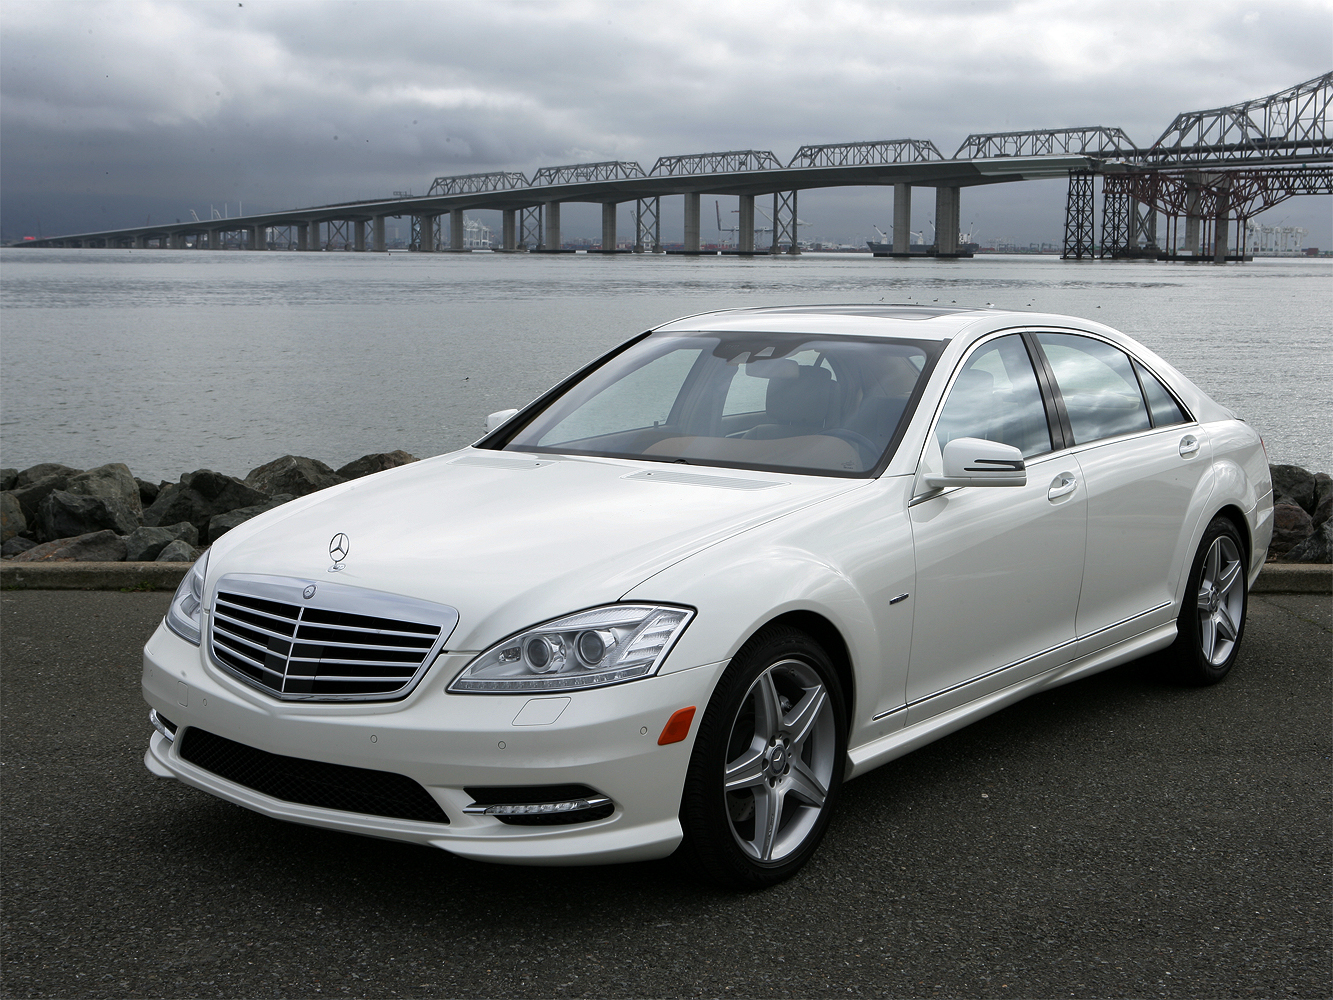

00118.jpg confidence:  17.670515060424805


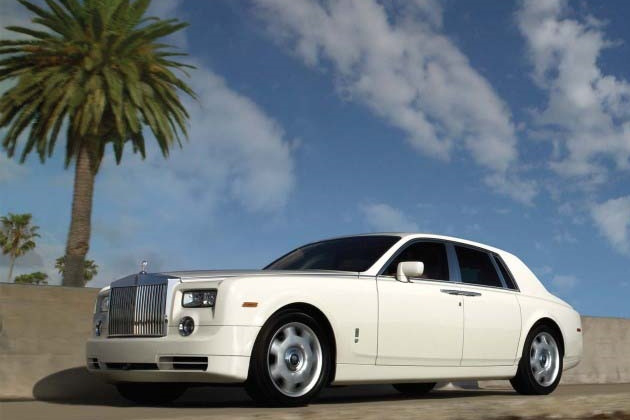

In [35]:
display(Image.open(dataset_dir + "cars_test/00025.jpg"))
print(classes[predicted.item()], "confidence: ", conf.item())
display(Image.open(dataset_dir + "cars_train/" + classes[predicted.item()]))